# Uber Demand Gap Project

## Notebook by `Arunava Chakraborty`

### Introduction

Uber found a business problem where there was a demand gap for cars from and to airports.

In this notebook we are gonna use a dataset which focuses on just 4 days form the Uber Data WareHouse.

Using this dataset, we are gonna try to reason out the possible causes of the problem.

### Required libraries

1) Numpy

2) Pandas

3) Matplotlib

4) Seaborn

### 1) Analysing the given data

Let's start by analysing the given data. And let's look if there are any missing values or if any data can be derived from the existing data.

In [1]:
# Requried imports and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Functions
def datevld(s):
    # Dropping year as its consistent across the dataset
    if s == 'NA': return s
    s = ''.join(list(map(lambda x : '-' if x == '/' else x, s))[:-5])
    return s

def timevld(s):
    if s == 'NA': return s
    if len(s) <= 5:
        #s = ':'.join(s.split(':')[:2])
        s += ':00'
    return s

In [2]:
# Reading the data
df = pd.read_csv('./Uber Request Data.csv')
data_size = len(df)
column_headers = list(df)

column_headers

['Request id',
 'Pickup point',
 'Driver id',
 'Status',
 'Request timestamp',
 'Drop timestamp']

`Request id` seems to be unique across the dataset and thus we will set it as the index of the dataset.

But before, that we have to make sure that there are no duplicacies in the data in terms of the `Request id`.

If so, we need to remove the duplicate rows.

In [3]:
# Checking if all the requests are unique
data_size == len(df['Request id'].value_counts(ascending=True))

True

Thus, we can see that all `Request id`s are unique and thus can be set as the index.

In [4]:
# Setting index to `Request id`
df = df.set_index('Request id')

### 2) Cleaning the data

Let's divide the column `Request timestamp` into `Request Date` and `Request Time` such that we can plot data based on the date and time.

In [5]:
# Dividing the 'Request timestamp' column into 'Request Date' and 'Request Time'
df['Request timestamp'] = df['Request timestamp'].apply(lambda x : x.split())

df['Request Date'] = df['Request timestamp'].apply(lambda x : x[0])
df['Request Time'] = df['Request timestamp'].apply(lambda x : x[1])

Let's divide the column `Drop timestamp` into `Drop` and `Drop Time` such that we can plot data based on the date and time.

In [6]:
# Dividing the 'Drop timestamp' column into 'Drop Date' and 'Drop Time'
df['Drop timestamp'] = df['Drop timestamp'].apply(lambda x : x.split() if type(x) == str else ['NA', 'NA'])

df['Drop Date'] = df['Drop timestamp'].apply(lambda x : x[0])
df['Drop Time'] = df['Drop timestamp'].apply(lambda x : x[1])

Let's now drop the `Request timestamp` and `Drop timestamp` columns as they are not needed

In [7]:
# Dropping 'Request timestamp' and 'Drop timestamp'
df = df.drop(['Request timestamp', 'Drop timestamp'], axis=1)

Changing the date columns to just keep the day as month and year is consistent all along the dataset

In [8]:
# Changing the dates to one specified format
df['Request Date'] = df['Request Date'].apply(datevld)
df['Drop Date'] = df['Drop Date'].apply(datevld)

Changing the time columns to add the seconds part for ones which are missing

In [9]:
# Changing the time to one specified format
df['Request Time'] = df['Request Time'].apply(timevld)
df['Drop Time'] = df['Drop Time'].apply(timevld)

In [10]:
# Dropping the month as month is consistent across
df['Request Date']  = df['Request Date'].apply(lambda x : x.split('-')[0])
df['Drop Date']  = df['Drop Date'].apply(lambda x : x.split('-')[0] if x != 'NA' else x)

In [11]:
# Changing the columns to numeric type
df['Drop Date'] = pd.to_numeric(df['Drop Date'], errors="coerce")
df['Request Date'] = pd.to_numeric(df['Request Date'], errors="coerce")

In [12]:
# Changing required columns to time type
df['Drop Time']    = pd.to_datetime(df['Drop Time'], format='%H:%M:%S', errors="coerce").dt.time
df['Request Time'] = pd.to_datetime(df['Request Time'], format='%H:%M:%S', errors="coerce").dt.time

In [13]:
# Quick Peek
df.iloc[2825:2835]

,Pickup point,Driver id,Status,Request Date,Request Time,Drop Date,Drop Time
Request id,,,,,,,
6304,City,299.0,Trip Completed,15,18:31:31,15.0,19:19:30
1315,Airport,300.0,Trip Completed,11,22:54:00,11.0,23:35:00
2924,City,300.0,Trip Completed,13,06:31:22,13.0,07:20:52
3324,Airport,300.0,Trip Completed,13,12:33:21,13.0,13:16:03
3935,Airport,300.0,Trip Completed,13,22:26:08,13.0,23:43:13
5844,Airport,300.0,Trip Completed,15,09:07:09,15.0,09:56:07
2905,City,1.0,Cancelled,13,06:08:41,NaN,NaN
4805,City,1.0,Cancelled,14,17:07:58,NaN,NaN
5202,Airport,1.0,Cancelled,14,20:51:37,NaN,NaN


### 4) Analysing the data

Let's get a quick look at how much of the requests are `Completed`, `Cancelled` and `No Cars Available`

In [14]:
# Descriptive Statistics Summary of 'Status' of Requests
df['Status'].value_counts()

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

Quick look says that requests that result in `No cars available` are almost double the number of `trips completed`

Lets take a look at the status statistically plotting it across all days.

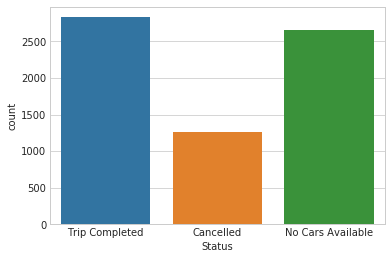

In [15]:
# Combining across all days
sns.countplot(df['Status'])
plt.show()

Plotting the status of requests for each day to analyze if the problem is  true only for certain days.

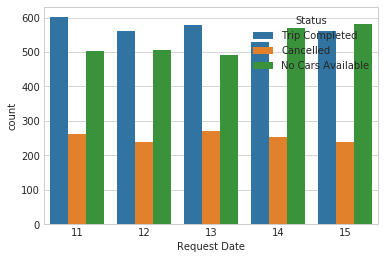

In [16]:
# Analysing each day trends
sns.countplot(x='Request Date', hue='Status', data=df)
plt.show()

Taking a look at the above graph it seems that problem remains the same across all days.

Thus, going in more granularity, and looking at the time, in which the problems occur mostly by plotting a graph of the staus requests at particular time of the day.

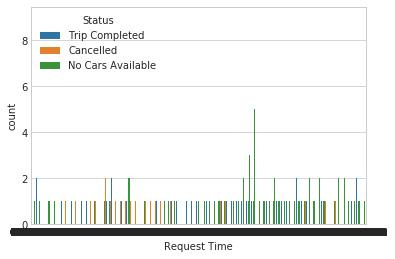

In [17]:
# Plot to show :
# 1) For Maximum trips cars are unavailable
# 2) Very few Trips are completed
# 3) 'No cars available' are during mostly during the night time
# 4) 'Cancelled' maximum during office hours and, in general, day time when the rush is more
df1 = df.sort_values(by=['Request Time'])
sns.countplot(x='Request Time', hue='Status', data=df1)
plt.show()

Looking at the above plot we can sure say that most of the times cars are unavailable and many are cancelled.

Unavaibility of cars seems to be the most during the night time. And cancelled requests are spread across with concentration during the day time when the rush is more (requests for cars are more)

Let's create a plot to see if there is a relationship between the `Pickup point` and the `Status`

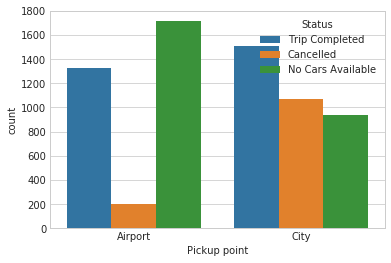

In [18]:
# Plot to show:
# 1) Most trips are 'Cancelled' from City to Airport
# 2) Unavaibility of cars is more seen at the Airport
sns.countplot(x='Pickup point', hue='Status', data=df)
plt.show()

Well, it turns out there is a relationship.

Drivers mostly cancel when the ride is from City to Airport

And the unavaibility of cars are more at the Airports

## Conclusion

1) Hiring more cars for the night shift can almost double the success of the
   business

2) Seems that cars have to spend more fuel and time to go the airport. 

       a) And as a result of that, they are waiting at they airport for a customer as driving
   
       b) Back without a customer would cost double on the fuel.
   
       c) Due to uncertain landing times, cars have to wait for long.
   
       d) In which time, if they were not at airport they could have made a lot of money.
   
       e) This is why, most cars cancel trips from City -> Airport.

   Thus, IMO, increasing the fare for trips to and from Airport can make a decrease
   In the rate of the trip cancellations by the driver.